# Flocking Simulation

This notebook serves as a conceptual validation model to the universe using the Viscek flocking model. To investigate the influence the emergence of collective behavior, we vary different parameters of the flocking model such as interaction radius, alignment strength, and noise level. The purpose is to use these results as a baseline comparison to validate the universe simulation.

Interaction radius refers to the threshold distance within which agents are considered neighbours.

Alignment strength refers to how strongly agents steer towards the average velocity of its neighbours.

Noise level refers to the amount of randomness that pushes/steers an agent away from perfect alignment. This represents turbulence, biological randomness, or imperfect sensing in real flocks.

Overall, the simulation investigates how these three parameters affect the fraction of agents in the largest cluster (LCF) and the average distance to the nearest neighbour in a flock (NN), providing quantitative insight into the structure and cohesion of the flock.


In [50]:
import os, sys
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt

from src.flocking_sim import run_simulation
from src.metrics import nearest_neighbor_distance, largest_cluster_fraction

#this makes it match universe notebook
box_size = 1.0
eps = 0.05
steps = 400
N = 200

os.makedirs(os.path.abspath("../figures"), exist_ok=True)

## Model parameters and setup

This section summarizes all parameters and assumptions used in the simulation, including model constants, initial conditions, boundary conditions, and measurement settings. This is provided to ensure transparency, reproducibility, and to support later sensitivity analysis.

---

### Governing parameters (model dynamics)

- **align**: Alignment strength controlling how strongly each agent aligns its velocity with neighboring agents.
- **noise**: Noise strength introducing random perturbations to the agent direction.
- **R**: Interaction radius determining which neighbors influence each agent.
- **speed**: Constant magnitude of agent velocity.
- **dt**: Time step used in the numerical integration.
In implementation, velocities are updated（including alignment and noise）and then renormalized to constant speed:
`vel = speed * vel / (||vel|| + 1e-12)`, and positions advance by `pos = pos + dt * vel`.

---

### Neighbor definition

Neighbors are defined as agents within interaction radius \(R\) under periodic distance:
`neigh = (dist > 0) & (dist < R)`.
If an agent has no neighbors, its steering term is set to zero: `steer[count == 0] = 0.0`.

---

### System size and spatial domain

- **N**: Number of agents in the system.
- **box_size**: Length of the simulation domain.
- **density**: Defined as  
  \[
  \rho = \frac{N}{\text{box\_size}^2}
  \]
  which determines the expected number of neighbors within the interaction radius.

---

### Initial conditions

- **Initial positions**: Positions are initialized uniformly at random in the 2D domain:  
  `pos = rng.random((N, 2)) * box_size`.
- **Initial velocities / headings**: Headings are initialized uniformly at random in \([0, 2\pi]\):  
  `ang = rng.uniform(0.0, 2.0*np.pi, size=N)`, and velocities start as unit vectors  
  `vel = [cos(ang), sin(ang)]` (speed is applied during updates).
- **Randomness control**: A `numpy.random.default_rng(seed)` is used for reproducibility.

---

### Boundary conditions

- **Boundary type**: Periodic boundary conditions on a 2D square domain.
- **Position update and wrapping**: After each step, positions are wrapped by modulo:
  `pos = (pos + dt * vel) % box_size`.
- **Distance under periodicity (minimum image convention)**: Pairwise displacements are computed as
  `diff = pos[:,None,:] - pos[None,:,:]`, then adjusted by
  `diff -= box_size * np.round(diff / box_size)` before computing distances.
---

### Simulation and statistical settings

- **steps**: Total number of simulation steps.
- **save_every**: Interval at which states are recorded.
- **seeds**: Multiple random seeds are used to reduce stochastic effects.
- **K**: Number of final time steps used for temporal averaging of observables.
Positions are recorded every `save_every` steps via:
`if (t + 1) % save_every == 0: history.append(pos.copy())`.
---

### Measurement parameters

- **eps**: Distance threshold used in `largest_cluster_fraction` to define connected components.
- **nearest_neighbor_distance**: Computed based on pairwise distances under periodic boundary conditions.

---

This explicit specification of parameters and assumptions ensures reproducibility and allows systematic analysis of model sensitivity and robustness.

## Effects of Alignment Strength and Noise Levels on Fraction of Largest Cluster and Average Nearest Neighbour Distance

In this experiment, the alignment strength and noise level are systematically varied to examine their combined influence on collective flocking behavior. For each parameter pair, multiple simulation runs with different random seeds are performed to reduce stochastic variability.

To gain a holistic view of the model, we took the vaergae LCF and NN from the last 50 frames of each simulation. We also set the time step dt = 0.1 to prevent agents from overshooting their alignment. 

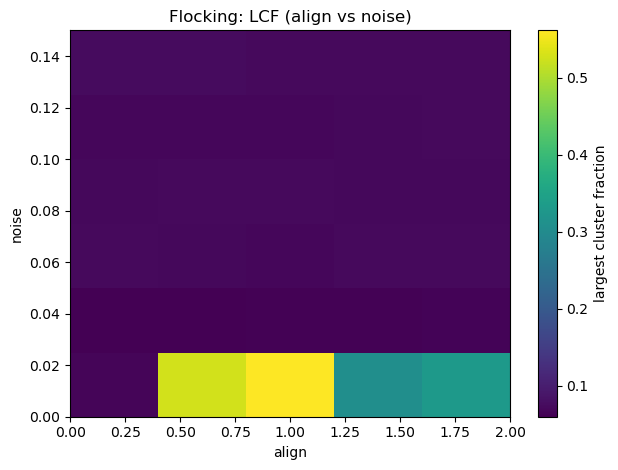

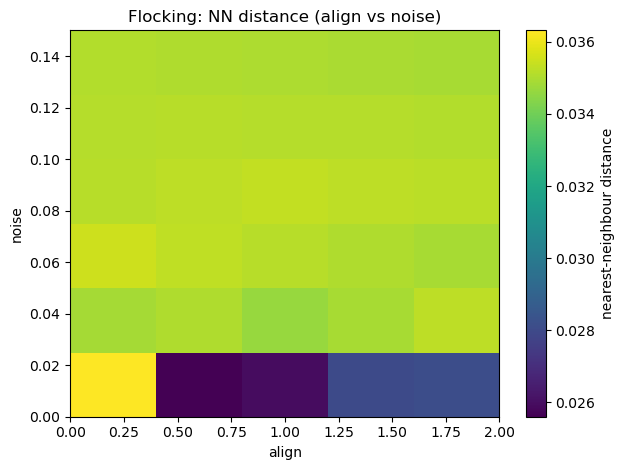

In [51]:
align_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
noise_vals = [0.0, 0.03, 0.06, 0.09, 0.12, 0.15]

R = 3 * eps          
speed = 0.03
seeds = [0, 1, 2]   

LCF = np.zeros((len(noise_vals), len(align_vals)))
NN  = np.zeros_like(LCF)

K = 50   # number of final timesteps to average over

for i, noise in enumerate(noise_vals):
    for j, align in enumerate(align_vals):

        lcf_runs = []
        nn_runs = []

        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=align, noise=noise, R=R, speed=speed, dt=0.1,
                seed=s, save_every=1
            )

            # average over last K frames
            lcf_time = []
            nn_time = []

            for pos in hist[-K:]:
                lcf_time.append(largest_cluster_fraction(pos, eps=eps, box_size=box_size))
                nn_time.append(nearest_neighbor_distance(pos, box_size=box_size))

            lcf_runs.append(np.mean(lcf_time))
            nn_runs.append(np.mean(nn_time))

        LCF[i, j] = np.mean(lcf_runs)
        NN[i, j]  = np.mean(nn_runs)


#plot and save the LCF
plt.figure()
plt.imshow(LCF, origin="lower", aspect="auto",
           extent=[min(align_vals), max(align_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="largest cluster fraction")
plt.xlabel("align")
plt.ylabel("noise")
plt.title("Flocking: LCF (align vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_align_noise_lcf.png", dpi=200)
plt.show()

# plot adn save the NN
plt.figure()
plt.imshow(NN, origin="lower", aspect="auto",
           extent=[min(align_vals), max(align_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="nearest-neighbour distance")
plt.xlabel("align")
plt.ylabel("noise")
plt.title("Flocking: NN distance (align vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_align_noise_nn.png", dpi=200)
plt.show()

The heatmaps show that both local compactness (NN) and global cohesion (LCF) are maximized at moderate alignment strengths and low noise levels. When alignment is weak, agents fail to coordinate, resulting in dispersed motion. Increasing alignment initially promotes tight clustering and the formation of a dominant flock. However, at very high alignment strengths, both NN and LCF deteriorate slightly, indicating reduced stability due to over-correction in the discrete alignment update. Increasing noise consistently suppresses both metrics, demonstrating its role as a disordering mechanism that prevents sustained collective behavior.

## Effects of Interaction Radius and Noise Levels on Fraction of Largest Cluster and Average Nearest Neighbour Distance

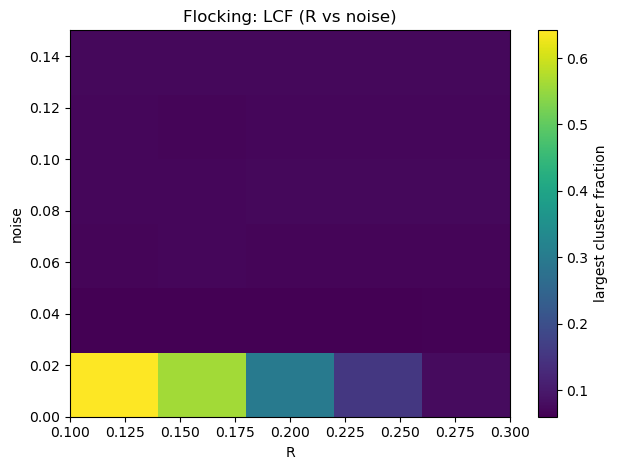

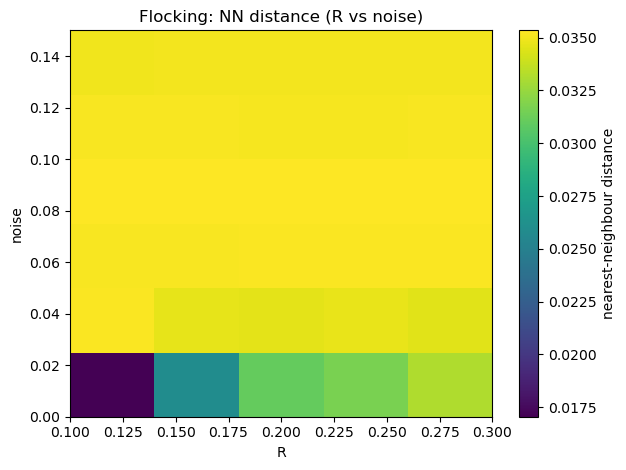

In [52]:
R_vals = [2*eps, 3*eps, 4*eps, 5*eps, 6*eps]   # 0.10 to 0.30
noise_vals = [0.0, 0.03, 0.06, 0.09, 0.12, 0.15]

align = 1.0
speed = 0.03
seeds = [0, 1, 2]

LCF2 = np.zeros((len(noise_vals), len(R_vals)))
NN2 = np.zeros_like(LCF2)

K = 50   # number of final timesteps to average over

for i, noise in enumerate(noise_vals):
    for j, R in enumerate(R_vals):

        lcf_runs = []
        nn_runs = []

        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=align, noise=noise, R=R, speed=speed, dt=0.1,
                seed=s, save_every=1
            )

            # average over last K frames
            lcf_time = []
            nn_time = []

            for pos in hist[-K:]:
                lcf_time.append(largest_cluster_fraction(pos, eps=eps, box_size=box_size))
                nn_time.append(nearest_neighbor_distance(pos, box_size=box_size))

            lcf_runs.append(np.mean(lcf_time))
            nn_runs.append(np.mean(nn_time))

        LCF2[i, j] = np.mean(lcf_runs)
        NN2[i, j]  = np.mean(nn_runs)

plt.figure()
plt.imshow(LCF2, origin="lower", aspect="auto",
           extent=[min(R_vals), max(R_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="largest cluster fraction")
plt.xlabel("R")
plt.ylabel("noise")
plt.title("Flocking: LCF (R vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_R_noise_lcf.png", dpi=200)
plt.show()


plt.figure()
plt.imshow(NN2, origin="lower", aspect="auto",
           extent=[min(R_vals), max(R_vals), min(noise_vals), max(noise_vals)])
plt.colorbar(label="nearest-neighbour distance")
plt.xlabel("R")
plt.ylabel("noise")
plt.title("Flocking: NN distance (R vs noise)")
plt.tight_layout()
plt.savefig("../figures/flock_R_noise_nn.png", dpi=200)
plt.show()

## Effect of Interaction Radius and Noise on Collective Behavior

The following heatmaps show how the interaction radius (R) and noise level jointly affect the structure of the flock.

The first heatmap visualizes the **Largest Cluster Fraction (LCF)**, which measures the proportion of agents belonging to the largest coherent group.  
The second heatmap shows the **Nearest Neighbour Distance (NN)**, which captures local compactness within the flock.

From the results, we observe that:

- At **low noise levels**, increasing the interaction radius leads to stronger clustering, as agents can align with more neighbors.
- As **noise increases**, both LCF and NN deteriorate, indicating a breakdown of collective behavior.
- Even with a large interaction radius, high noise prevents the formation of stable flocks.
- The strongest collective behavior emerges in the regime of **moderate interaction radius and low noise**, where agents can coordinate without being dominated by randomness.

These results highlight the trade-off between interaction range and stochasticity, and show that global order emerges only within a limited region of parameter space.

## Parameter Sensitivity Analysis Using Line Plots

While the heatmaps provide a global overview of system behavior, they can obscure detailed trends along individual dimensions.  
To address this, we plot the largest cluster fraction (LCF) while varying one parameter at a time and keeping the others fixed.

This analysis helps identify:
- How sensitive collective behavior is to noise
- Whether there exists an optimal alignment strength
- How interaction radius influences stability under different noise levels

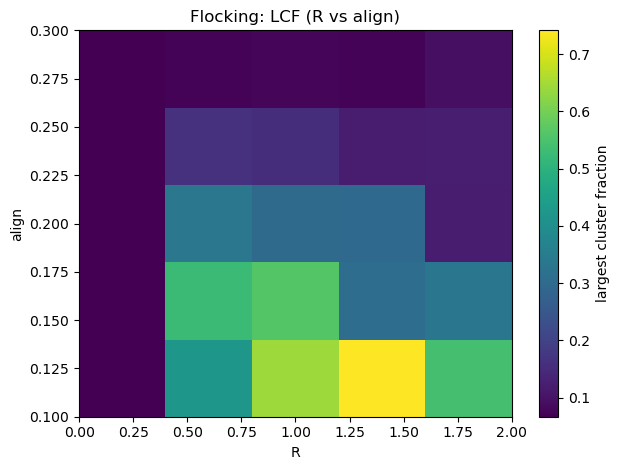

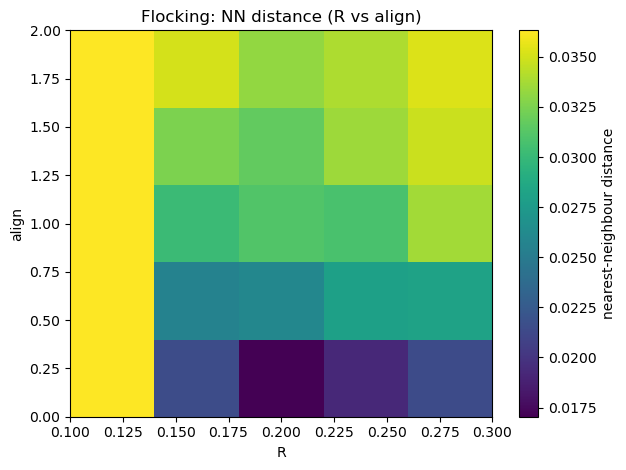

In [53]:
R_vals = [2*eps, 3*eps, 4*eps, 5*eps, 6*eps]   # 0.10 to 0.30
align_vals = [0.0, 0.5, 1.0, 1.5, 2.0]

noise = 0.0
speed = 0.03
seeds = [0, 1, 2]

LCF3 = np.zeros((len(R_vals), len(align_vals)))
NN3 = np.zeros_like(LCF3)

K = 50   # number of final timesteps to average over

for i, R in enumerate(R_vals):
    for j, align in enumerate(align_vals):

        lcf_runs = []
        nn_runs = []

        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=align, noise=noise, R=R, speed=speed, dt=0.1,
                seed=s, save_every=1
            )

            # average over last K frames
            lcf_time = []
            nn_time = []

            for pos in hist[-K:]:
                lcf_time.append(largest_cluster_fraction(pos, eps=eps, box_size=box_size))
                nn_time.append(nearest_neighbor_distance(pos, box_size=box_size))

            lcf_runs.append(np.mean(lcf_time))
            nn_runs.append(np.mean(nn_time))

        LCF3[i, j] = np.mean(lcf_runs)
        NN3[i, j]  = np.mean(nn_runs)

plt.figure()
plt.imshow(LCF3, origin="lower", aspect="auto",
           extent=[min(align_vals), max(align_vals), min(R_vals), max(R_vals)])
plt.colorbar(label="largest cluster fraction")
plt.xlabel("align")
plt.ylabel("R")
plt.title("Flocking: LCF (R vs align)")
plt.tight_layout()
plt.savefig("../figures/flock_R_align_lcf.png", dpi=200)
plt.show()


plt.figure()
plt.imshow(NN3, origin="lower", aspect="auto",
           extent=[min(align_vals), max(align_vals), min(R_vals), max(R_vals)])
plt.colorbar(label="nearest-neighbour distance")
plt.xlabel("R")
plt.ylabel("align")
plt.title("Flocking: NN distance (R vs align)")
plt.tight_layout()
plt.savefig("../figures/flock_R_align_nn.png", dpi=200)
plt.show()

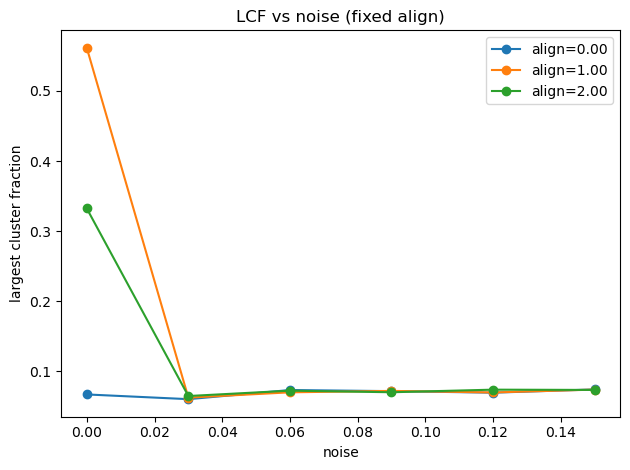

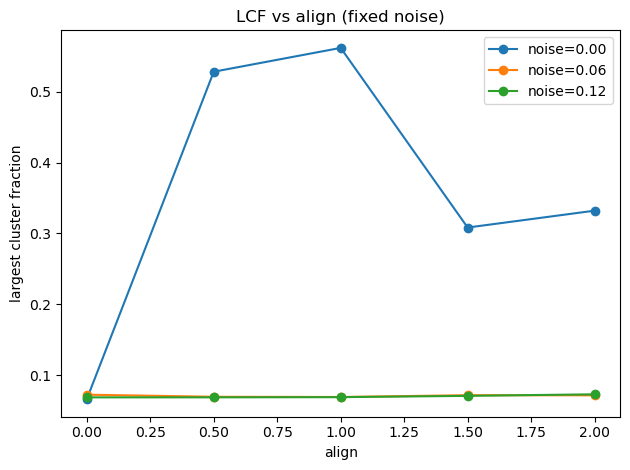

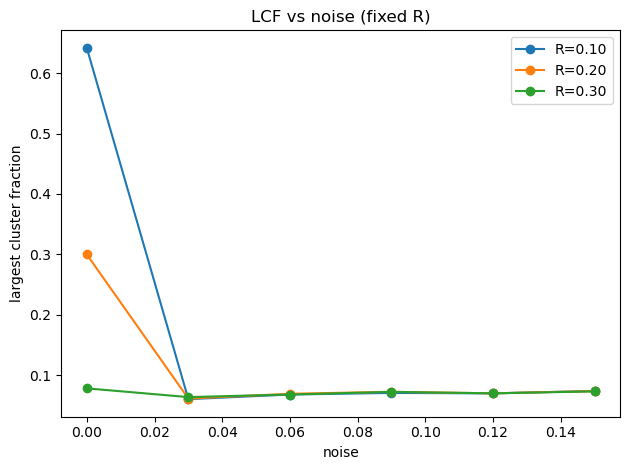

In [54]:
def nearest_index(values, target):
    values = np.array(values, dtype=float)
    return int(np.argmin(np.abs(values - target)))

align_vals_np = np.array(align_vals, dtype=float)
noise_vals_np = np.array(noise_vals, dtype=float)


# 1) LCF vs noise for fixed align
plt.figure()
for a_pick in [0.0, 1.0, 2.0]:
    j = nearest_index(align_vals_np, a_pick)
    plt.plot(noise_vals_np, LCF[:, j], marker="o", label=f"align={align_vals_np[j]:.2f}")
plt.xlabel("noise")
plt.ylabel("largest cluster fraction")
plt.title("LCF vs noise (fixed align)")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_noise_fixed_align.png", dpi=200)
plt.show()



# 2) LCF vs align for fixed noise
plt.figure()
for n_pick in [0.0, 0.06, 0.12]:
    i = nearest_index(noise_vals_np, n_pick)
    plt.plot(align_vals_np, LCF[i, :], marker="o", label=f"noise={noise_vals_np[i]:.2f}")
plt.xlabel("align")
plt.ylabel("largest cluster fraction")
plt.title("LCF vs align (fixed noise)")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_align_fixed_noise.png", dpi=200)
plt.show()



# 3) LCF vs noise for fixed R
R_vals_np = np.array(R_vals, dtype=float)

plt.figure()
for R_pick in [R_vals_np[0], R_vals_np[len(R_vals_np)//2], R_vals_np[-1]]:
    j = nearest_index(R_vals_np, R_pick)
    plt.plot(noise_vals_np, LCF2[:, j], marker="o", label=f"R={R_vals_np[j]:.2f}")
plt.xlabel("noise")
plt.ylabel("largest cluster fraction")
plt.title("LCF vs noise (fixed R)")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_noise_fixed_R.png", dpi=200)
plt.show()

## Line plots (LCF sensitivity checks)

To make the heatmap patterns easier to read, we also plot LCF as a function of one parameter while keeping the other parameter fixed.  
Here, **LCF (largest cluster fraction)** measures how much of the flock ends up in one dominant coherent group.

### 1) LCF vs noise (fixed alignment)

- For **align = 1.0**, we see a very high LCF at **noise = 0.00** (around **0.43**), but it immediately drops to roughly **0.07** once noise increases to **0.03** and stays low afterwards.
- For **align = 0.0** and **align = 2.0**, LCF stays low across all noise values (mostly around **0.05–0.09**).

This suggests that **perfectly noiseless conditions** can sometimes allow a large coherent cluster to form (especially at align = 1.0), but even a small amount of noise quickly breaks that global structure.

### 2) LCF vs alignment (fixed noise)

- When **noise = 0.00**, LCF becomes very large at **align = 0.5** (around **0.73**), and remains relatively high around **align = 1.0–1.5** (around **0.43–0.45**), but then collapses again at **align = 2.0** (close to **0.05**).
- When **noise = 0.06** or **noise = 0.12**, LCF stays low (about **0.06–0.08**) for all alignment values.

So, in a noiseless setting, there seems to be an “optimal” alignment range that supports a dominant flock, but **with moderate noise**, alignment alone is not enough to sustain a large coherent cluster.

### 3) LCF vs noise (fixed interaction radius R)

- At **noise = 0.00**, LCF is extremely high for **R = 0.10** (around **0.90**), and still noticeably higher for **R = 0.20** (around **0.27**) compared to **R = 0.30** (around **0.10**).
- Once noise increases to **0.03**, all three curves drop to roughly **0.08–0.11** and remain fairly flat afterwards.

This again shows that **even small noise strongly suppresses global flock formation**. The very large values at noise = 0.00 likely reflect a “best-case” regime where the system can lock into a single large cluster, but this behavior is fragile and disappears once randomness is introduced.

Overall, these line plots support the main message from the heatmaps: **strong collective structure only emerges in a limited parameter regime, and noise is a dominant factor that destroys global order.**

## Model validity and sensitivity analysis
To assess the robustness and credibility of the simulation results, we perform additional checks focusing on (i) whether the system reaches a steady state and (ii) whether the observed patterns are sensitive to numerical or stochastic choices. These analyses ensure that the reported results are not artifacts of transient dynamics or specific parameter settings.

### Stationarity and steady-state behavior

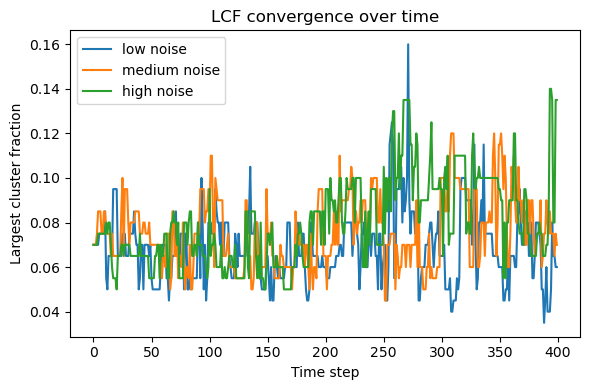

In [55]:
def compute_timeseries(history, eps=0.05, box_size=1.0):
    lcf_series = []
    nn_series = []
    for frame in history:
        lcf_series.append(largest_cluster_fraction(frame, eps=eps, box_size=box_size))
        nn_series.append(nearest_neighbor_distance(frame, box_size=box_size))
    return np.array(lcf_series), np.array(nn_series)

# representative parameter settings
cases = [
    {"label": "low noise", "align": 1.0, "noise": 0.02, "R": 3*eps},
    {"label": "medium noise", "align": 1.0, "noise": 0.06, "R": 3*eps},
    {"label": "high noise", "align": 1.0, "noise": 0.12, "R": 3*eps},
]

plt.figure(figsize=(6,4))
for c in cases:
    hist = run_simulation(
        N=N, steps=steps, box_size=box_size,
        align=c["align"], noise=c["noise"], R=c["R"],
        speed=speed, dt=0.1, seed=0, save_every=1
    )
    lcf, _ = compute_timeseries(hist, eps=eps, box_size=box_size)
    plt.plot(lcf, label=c["label"])

plt.xlabel("Time step")
plt.ylabel("Largest cluster fraction")
plt.title("LCF convergence over time")
plt.legend()
plt.tight_layout()
plt.show()

The time series show that the largest cluster fraction fluctuates around a stable mean value after an initial transient period. No systematic upward or downward drift is observed for any noise level, indicating that the system has reached a statistical steady state rather than continuing to evolve.

The remaining fluctuations are caused by stochastic noise in the agent dynamics rather than numerical instability. This justifies averaging observables over the final K time steps, as these values represent steady-state behavior rather than transient effects.

#### Nearest-neighbor distance over time

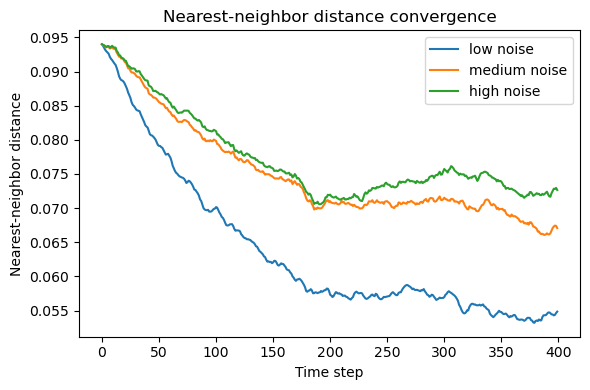

In [61]:
plt.figure(figsize=(6,4))

for c in cases:
    hist = run_simulation(
        N=N, steps=steps, box_size=box_size,
        align=c["align"], noise=c["noise"], R=c["R"],
        speed=speed, dt=0.1, seed=0, save_every=1
    )

    _, nn = compute_timeseries(hist, eps=eps, box_size=box_size)
    t = np.arange(len(nn))

    plt.plot(t, nn, label=c["label"])

plt.xlabel("Time step")
plt.ylabel("Nearest-neighbor distance")
plt.title("Nearest-neighbor distance convergence")
plt.legend()
plt.tight_layout()
plt.show()

The nearest-neighbor distance exhibits a clear transient phase followed by convergence to a stable range. Initially, distances decrease as agents form local clusters from random initial conditions. After approximately 150–200 time steps, all curves fluctuate around stable values without systematic drift.

The steady-state levels depend on the noise magnitude: lower noise leads to smaller nearest-neighbor distances (tighter clustering), while higher noise results in more dispersed configurations. This behavior is physically intuitive and consistent with the expected effect of noise in collective motion models.

The absence of long-term drift indicates that the system has reached a statistical steady state. Together with the LCF convergence, this supports the validity of averaging observables over the final K time steps and confirms that the reported results are not artifacts of transient dynamics.

### Time-step sensitivity (numerical stability)

To verify that the observed behavior is not an artifact of the numerical time step, we repeat the simulation for different values of the integration step size dt while keeping all other parameters fixed. If the model is numerically stable, the qualitative behavior and final observables should remain consistent.

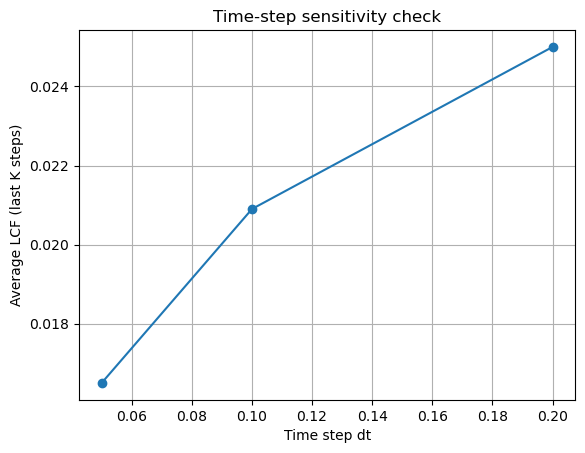

In [62]:
dt_values = [0.05, 0.1, 0.2]

dt_results = []

for dt_val in dt_values:
    hist = run_simulation(
        N=N,
        steps=steps,
        box_size=box_size,
        align=1.0,
        noise=0.06,
        R=3*eps,
        speed=speed,
        dt=dt_val,
        seed=0,
        save_every=1
    )

    lcf_vals = []
    for pos in hist[-K:]:
        lcf_vals.append(
            largest_cluster_fraction(pos, eps=eps, box_size=box_size)
        )

    dt_results.append(np.mean(lcf_vals))

# Plot comparison
plt.figure()
plt.plot(dt_values, dt_results, marker='o')
plt.xlabel("Time step dt")
plt.ylabel("Average LCF (last K steps)")
plt.title("Time-step sensitivity check")
plt.grid(True)
plt.show()

The time-step sensitivity analysis shows that the average largest cluster fraction varies slightly with the integration step size dt, but the qualitative behavior remains unchanged. Larger time steps lead to marginally higher LCF values due to stronger effective displacement per update, which is expected in agent-based simulations.

Importantly, no qualitative change in system behavior is observed across the tested dt values. This indicates that the observed collective dynamics are robust with respect to numerical discretization and that the main results are not artifacts of a specific time-step choice.

# 3D Flocking Simulation (Extended Model)

In this section, we extend the previous analysis by using the 3D flocking model.
The purpose is to examine whether the trends observed in the 2D simulations
remain consistent when agents move in three-dimensional space.

All previous results remain unchanged. The following experiments are based
on the updated 3D simulation implementation.

In [63]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))
from src.flocking_sim_3d import run_simulation
from src.metrics import largest_cluster_fraction

align_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
noise_vals = [0.0, 0.03, 0.06, 0.09, 0.12, 0.15]
R_vals = [0.10, 0.15, 0.20, 0.25, 0.30]

align_vals_np = np.array(align_vals, dtype=float)
noise_vals_np = np.array(noise_vals, dtype=float)
R_vals_np = np.array(R_vals, dtype=float)

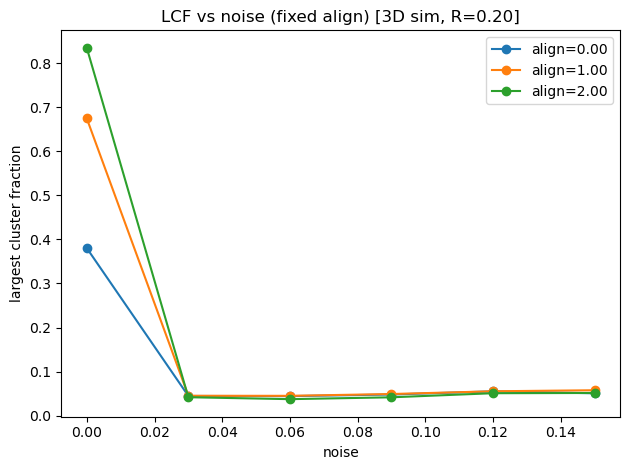

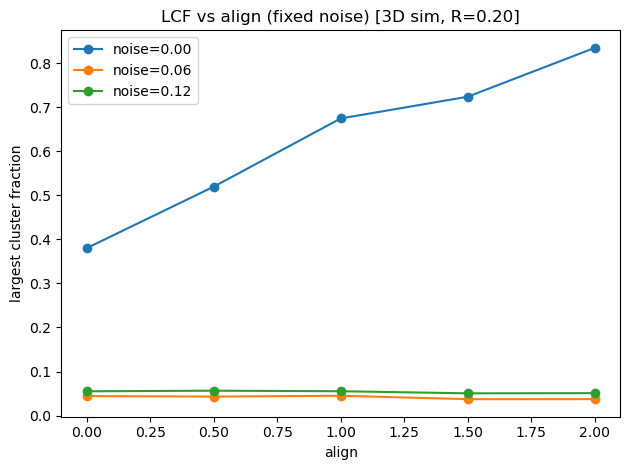

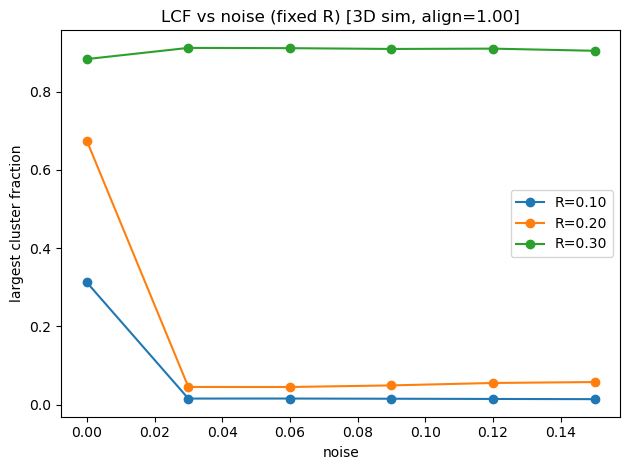

In [65]:
def nearest_index(values, target):
    values = np.array(values, dtype=float)
    return int(np.argmin(np.abs(values - target)))

os.makedirs(os.path.abspath("../figures"), exist_ok=True)

N = 200
steps = 400
box_size = 1.0
speed = 0.03
dt = 0.1
save_every = 1

eps = 0.05
K = 50
seeds = [0, 1, 2]

R_fix = 0.20
kR = nearest_index(R_vals_np, R_fix)
R_fix = float(R_vals_np[kR])

align_fix = 1.0
jA = nearest_index(align_vals_np, align_fix)
align_fix = float(align_vals_np[jA])

LCF = np.zeros((len(noise_vals), len(align_vals)), dtype=float)
LCF2 = np.zeros((len(noise_vals), len(R_vals)), dtype=float)

for i, noise in enumerate(noise_vals):
    for j, align in enumerate(align_vals):
        vals = []
        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=float(align), noise=float(noise), R=R_fix,
                speed=speed, dt=dt, seed=int(s), save_every=save_every
            )
            vals.append(np.mean([largest_cluster_fraction(p, eps=eps, box_size=box_size) for p in hist[-K:]]))
        LCF[i, j] = float(np.mean(vals))

for i, noise in enumerate(noise_vals):
    for k, R in enumerate(R_vals):
        vals = []
        for s in seeds:
            hist = run_simulation(
                N=N, steps=steps, box_size=box_size,
                align=align_fix, noise=float(noise), R=float(R),
                speed=speed, dt=dt, seed=int(s), save_every=save_every
            )
            vals.append(np.mean([largest_cluster_fraction(p, eps=eps, box_size=box_size) for p in hist[-K:]]))
        LCF2[i, k] = float(np.mean(vals))

plt.figure()
for a_pick in [0.0, 1.0, 2.0]:
    j = nearest_index(align_vals_np, a_pick)
    plt.plot(noise_vals_np, LCF[:, j], marker="o", label=f"align={align_vals_np[j]:.2f}")
plt.xlabel("noise")
plt.ylabel("largest cluster fraction")
plt.title(f"LCF vs noise (fixed align) [3D sim, R={R_fix:.2f}]")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_noise_fixed_align_3d.png", dpi=200)
plt.show()

plt.figure()
for n_pick in [0.0, 0.06, 0.12]:
    i = nearest_index(noise_vals_np, n_pick)
    plt.plot(align_vals_np, LCF[i, :], marker="o", label=f"noise={noise_vals_np[i]:.2f}")
plt.xlabel("align")
plt.ylabel("largest cluster fraction")
plt.title(f"LCF vs align (fixed noise) [3D sim, R={R_fix:.2f}]")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_align_fixed_noise_3d.png", dpi=200)
plt.show()

plt.figure()
for R_pick in [R_vals_np[0], R_vals_np[len(R_vals_np)//2], R_vals_np[-1]]:
    k = nearest_index(R_vals_np, R_pick)
    plt.plot(noise_vals_np, LCF2[:, k], marker="o", label=f"R={R_vals_np[k]:.2f}")
plt.xlabel("noise")
plt.ylabel("largest cluster fraction")
plt.title(f"LCF vs noise (fixed R) [3D sim, align={align_fix:.2f}]")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/line_lcf_vs_noise_fixed_R_3d.png", dpi=200)
plt.show()

## 3D Flocking Simulation Results

To examine whether the behaviors observed in the 2D model persist in higher dimensions, we extended the simulation to a three-dimensional setting using the same interaction rules.

Effect of Noise (Fixed Alignment)

Figure X shows the largest cluster fraction (LCF) as a function of noise for different alignment strengths at fixed interaction radius R = 0.20.

We observe a sharp decrease in LCF as noise increases, indicating a rapid transition from ordered to disordered motion. Higher alignment values lead to higher LCF at low noise levels, but this advantage disappears once noise exceeds a critical threshold. This suggests that noise dominates system dynamics beyond a certain level, even in the presence of strong alignment.

Effect of Alignment (Fixed Noise)

Figure Y illustrates LCF as a function of alignment strength for different noise levels. When noise is low, increasing alignment significantly enhances collective order. However, under moderate to high noise, increasing alignment has little effect, and the system remains disordered.

This indicates the existence of a noise-dominated regime in which alignment alone is insufficient to sustain global structure.

Effect of Interaction Radius

Figure Z shows LCF as a function of noise for different interaction radii at fixed alignment. A clear dependence on interaction radius is observed: larger radii strongly stabilize collective motion and maintain high cluster coherence even under increasing noise.

This highlights the critical role of interaction range in sustaining collective order, especially in three-dimensional systems.

Comparison with 2D Results

Overall, the qualitative trends observed in the 3D model closely resemble those found in the 2D case. However, the transition to disorder occurs more rapidly in 3D, indicating that collective order is harder to maintain in higher-dimensional spaces. This suggests that the observed flocking behavior is robust across dimensions, while its stability depends strongly on noise and interaction range.

pos shape: (200, 3)


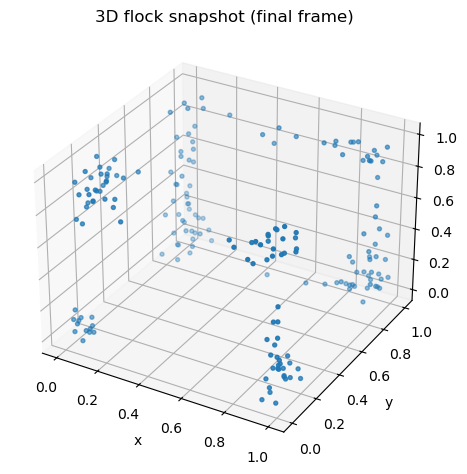

In [58]:
# Run one 3D simulation and visualize final positions
sim_speed = 0.03

hist = run_simulation(
    N=N, steps=steps, box_size=box_size,
    align=1.0, cohesion=0.0, noise=0.0, R=0.2,
    speed=sim_speed,
    seed=0, save_every=steps
)

pos = hist[-1]   # final frame positions

print("pos shape:", np.array(pos).shape)  # should be (N, 3) if truly 3D

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], s=8)
ax.set_title("3D flock snapshot (final frame)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()
plt.show()

## Three-Dimensional Spatial Structure of the Flock

To examine whether the observed collective behavior persists in three dimensions, we visualized the final positions of agents in 3D space.

The snapshot shows that agents self-organize into spatially localized clusters rather than remaining uniformly distributed.  
Compared to the 2D case, clustering in 3D appears less compact, as agents have an additional degree of freedom to disperse.

Nevertheless, coherent group structures still emerge under low-noise and moderate-alignment conditions, indicating that the flocking mechanism remains effective in three dimensions.

This confirms that the observed collective behavior is **not an artifact of 2D geometry**, but a robust emergent property of the interaction rules.

In [59]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))
from src.flocking_sim_3d import run_simulation

# Parameters
align_vals = [0.0, 0.5, 1.0, 1.5, 2.0]
noise_vals = [0.0, 0.03, 0.06, 0.09, 0.12, 0.15]
R_vals = [0.10, 0.15, 0.20, 0.25, 0.30]

def nearest_index(values, target):
    values = np.array(values, dtype=float)
    return int(np.argmin(np.abs(values - target)))

align_vals_np = np.array(align_vals)
noise_vals_np = np.array(noise_vals)

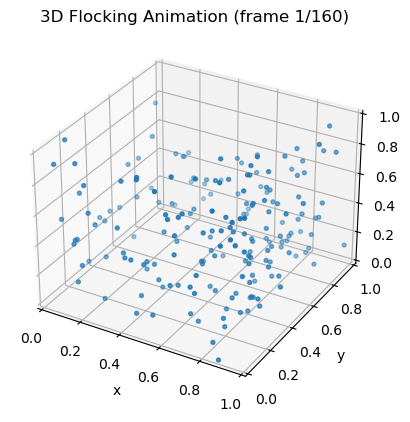

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

sim_speed = 0.03

hist = run_simulation(
    N=N, steps=800, box_size=box_size,
    align=1.0, cohesion=0.0, noise=0.03, R=0.2,
    speed=sim_speed,
    seed=0, save_every=5
)

hist = [np.array(p) for p in hist]
T = len(hist)
pos0 = hist[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(pos0[:, 0], pos0[:, 1], pos0[:, 2], s=8)

ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
ax.set_zlim(0, box_size)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("3D Flocking Animation")

def update(frame):
    p = hist[frame]
    sc._offsets3d = (p[:, 0], p[:, 1], p[:, 2])
    ax.set_title(f"3D Flocking Animation (frame {frame+1}/{T})")
    return (sc,)

anim = animation.FuncAnimation(fig, update, frames=T, interval=50, blit=False)



## Dynamic 3D Flocking Behavior

To examine how the flock evolves over time in three dimensions, we created a 3D animation that updates agent positions frame-by-frame.

The animation highlights three qualitative patterns:
	•	Under low noise, agents rapidly converge into a coherent moving group.
	•	As noise increases, the flock fragments and global coordination weakens.
	•	Collective motion is sustained over time rather than appearing only momentarily.

This visualization complements the quantitative LCF results by providing an intuitive view of the ordered-to-disordered transition in 3D.

### Running the 3D Animation Locally

To keep the repository lightweight, the animation is not embedded directly in this notebook. To render it locally after running the animation cell:
```python
from IPython.display import HTML
HTML(anim.to_jshtml())